In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import torch
import xarray as xr
from neuralhydrology.datasetzoo import get_dataset
from neuralhydrology.datautils.utils import load_scaler
from neuralhydrology.modelzoo.cudalstm import CudaLSTM
from neuralhydrology.modelzoo.customlstm import CustomLSTM
from neuralhydrology.modelzoo.ealstm import EALSTM
from neuralhydrology.utils.config import Config
from torch.utils.data import DataLoader

# setting device on GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print()

# Additional Info when using cuda
if device.type == "cuda":
    print(torch.cuda.get_device_name(0))
    print("Memory Usage:")
    print("Allocated:", round(torch.cuda.memory_allocated(0) / 1024**3, 1), "GB")
    print("Cached:   ", round(torch.cuda.memory_reserved(0) / 1024**3, 1), "GB")

Using device: cuda

NVIDIA GeForce RTX 4080 SUPER
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [3]:


def get_morris_gradient(
    model: torch.nn.Module, loader: torch.utils.data.DataLoader
) -> torch.Tensor:
    """Calculate gradients w.r.t static network inputs.

    TODO: Update Docstring with ref to paper

        Parameters
    ----------
    model : nn.Module
        The PyTorch model to train
    loader : DataLoader
        PyTorch DataLoader containing the basin data in batches.

    Returns
    -------
    torch.Tensor
        [description]
    """
    model.eval()
    grads = []
    for x_d, y, _, x_s, _ in loader.values():
        model.zero_grad()
               
        x_s = torch.autograd.Variable(x_s, requires_grad=True)
        x_d, x_s = x_d.to(DEVICE), x_s.to(DEVICE)
        p = model(loader)["y_hat"].to(DEVICE)
        grad = torch.autograd.grad(
            p, x_s, grad_outputs=torch.ones_like(y).to(DEVICE), create_graph=False
        )
        grads.append(grad[0][:, 0, :].detach().cpu().numpy())
    return np.concatenate(grads, axis=0)

In [4]:
cfg_path = Path("./model_runs/ealstm_q_mm_day_mswep_no_static_0205_144958/config.yml")
ealstm_cfg = Config(cfg_path)

# read attributes
# attributes = pd.read_csv(
#     "../data/attributes/static_with_height.csv",
#     dtype={"gauge_id": str},
#     index_col="gauge_id",
# )
# attributes = attributes[ealstm_cfg.static_attributes]
# means = attributes.mean()
# stds = attributes.std()

# Initialize new model
# create a new model instance with random weights
ea_lstm = EALSTM(cfg=ealstm_cfg)

# load the trained weights into the new model.
model_path = ealstm_cfg.run_dir / "model_epoch038.pt"
model_weights = torch.load(
    str(model_path), map_location="cpu"
)  # load the weights from the file, creating the weight tensors on CPU
ea_lstm.load_state_dict(
    model_weights
)  # set the new model's weights to the values loaded from file

# load the dataset
scaler = load_scaler(ealstm_cfg.run_dir)
dataset = get_dataset(ealstm_cfg, is_train=False, period="test", scaler=scaler)
dataloader = DataLoader(
    dataset, batch_size=1024, shuffle=False, num_workers=0, collate_fn=dataset.collate_fn
)

In [7]:
DEVICE = "cpu"

loader = next(iter(dataloader))
{i: v.shape for i, v in loader.items()}
x_d = loader["x_d"]
x_s = loader["x_s"].unsqueeze(1)
# y = loader["per_basin_target_stds"].squeeze().unsqueeze(1)
y = loader["y"].squeeze().unsqueeze(1)
ea_lstm.zero_grad()


x_d, x_s = x_d.to(DEVICE), x_s.to(DEVICE)
p = ea_lstm(loader)

pred = p["y_hat"]
y = y.reshape(pred.shape)
x_s = torch.autograd.Variable(x_s, requires_grad=True)

In [29]:
y = y[:, -1, :]
pred = pred[:, -1, :]

In [89]:
{i: v.shape for i, v in p.items()}

{'h_n': torch.Size([1024, 365, 256]),
 'c_n': torch.Size([1024, 365, 256]),
 'y_hat': torch.Size([1024, 365, 1])}

In [30]:
torch.autograd.grad(
    pred, x_s, grad_outputs=torch.ones_like(y).to(DEVICE), create_graph=False
)

RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

In [32]:
x_s.shape

torch.Size([1024, 1, 17])

In [9]:
pred.shape

torch.Size([1024, 365, 1])

In [10]:
x_s.shape

torch.Size([1024, 1, 17])

In [12]:
torch.ones_like(y).shape

torch.Size([1024, 365, 1])

In [79]:
x_s

tensor([[[ 0.1850,  0.1410,  1.3218,  ...,  0.0122, -0.1729,  0.8232]],

        [[ 0.1850,  0.1410,  1.3218,  ...,  0.0122, -0.1729,  0.8232]],

        [[ 0.1850,  0.1410,  1.3218,  ...,  0.0122, -0.1729,  0.8232]],

        ...,

        [[ 0.0235,  0.2727,  0.7360,  ..., -0.1595,  0.0356,  1.3118]],

        [[ 0.0235,  0.2727,  0.7360,  ..., -0.1595,  0.0356,  1.3118]],

        [[ 0.0235,  0.2727,  0.7360,  ..., -0.1595,  0.0356,  1.3118]]],
       device='cuda:0', grad_fn=<ToCopyBackward0>)

In [48]:
loader["y"][:, -1, :].shape

torch.Size([1024, 1])

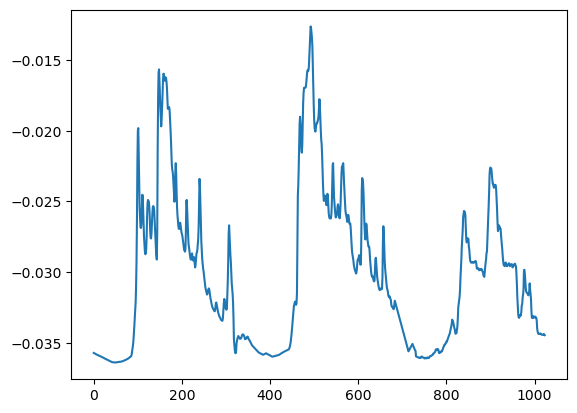

In [53]:
plt.plot(loader["y"][:, -1, :].detach().numpy())

In [11]:
loader['y'].shape

torch.Size([1024, 365, 1])

In [19]:
ea_lstm.eval()

ea_lstm.zero_grad()
p = ea_lstm(loader)

In [21]:
DEVICE = "cpu"

x_d, y, _, x_s, _ = loader.values()

x_s = x_s[0, :]

# y = torch.autograd.Variable(y, requires_grad=True)
y = torch.ones_like(y).to(DEVICE)
# _pred = torch.autograd.Variable(p["y_hat"], requires_grad=True)
_pred = p["y_hat"]
x_s = torch.autograd.Variable(x_s, requires_grad=True)

torch.autograd.grad(_pred, x_s, grad_outputs=y, create_graph=False)

RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

In [57]:
DEVICE = "cpu"




ea_lstm.eval()

# x_s = x_s[0]
x_s = torch.autograd.Variable(x_s, requires_grad=True).to(DEVICE)


pred = ea_lstm(loader)["y_hat"]

: 

In [56]:
grad = torch.autograd.grad(
    pred, x_s, grad_outputs=torch.ones_like(y).to(DEVICE), create_graph=False
)

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [55]:
y

tensor([[[    nan],
         [    nan],
         [    nan],
         ...,
         [    nan],
         [    nan],
         [-0.0357]],

        [[    nan],
         [    nan],
         [    nan],
         ...,
         [    nan],
         [-0.0357],
         [-0.0357]],

        [[    nan],
         [    nan],
         [    nan],
         ...,
         [-0.0357],
         [-0.0357],
         [-0.0357]],

        ...,

        [[    nan],
         [    nan],
         [    nan],
         ...,
         [-0.0332],
         [-0.0331],
         [-0.0331]],

        [[    nan],
         [    nan],
         [    nan],
         ...,
         [-0.0331],
         [-0.0331],
         [-0.0332]],

        [[    nan],
         [    nan],
         [    nan],
         ...,
         [-0.0331],
         [-0.0332],
         [-0.0332]]])

In [44]:
x_s.shape

torch.Size([1000, 17])

In [17]:



ea_lstm.zero_grad()

x_s = torch.autograd.Variable(x_s, requires_grad=True)
x_d, x_s = x_d.to(DEVICE), x_s.to(DEVICE)
x_s = x_s[0, :]

p = ea_lstm(loader)["y_hat"].to(DEVICE)
grad = torch.autograd.grad(
    p, x_s, grad_outputs=torch.ones_like(y).to(DEVICE), create_graph=False
)

RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

In [1]:
next(dataloader)

NameError: name 'dataloader' is not defined

In [21]:
shap.DeepExplainer(model=ea_lstm, data=loader)

AttributeError: 'dict' object has no attribute 'device'

tensor([ 0.1850,  0.1410,  1.3218, -0.5428,  0.5389, -0.3779,  0.0028, -0.3041,
        -0.2036, -0.0495,  0.6433,  0.5572, -0.0508,  0.1697,  0.0122, -0.1729,
         0.8232], grad_fn=<SliceBackward0>)

In [11]:
loader.keys()

dict_keys(['x_d', 'y', 'date', 'x_s', 'per_basin_target_stds'])

In [7]:
from tqdm.notebook import tqdm

feature_ranking = {}
for loader in tqdm(dataloader):
    gradients = get_morris_gradient(ea_lstm, loader)
    mean_abs_gradient = np.mean(np.abs(gradients), axis=0)

    # convert to pandas Series
    data = {}
    for name, value in zip(list(ealstm_cfg.static_attributes), mean_abs_gradient):
        data[name] = value
    # feature_ranking[basin] = pd.Series(data=data)

  0%|          | 0/813 [00:00<?, ?it/s]

ValueError: too many values to unpack (expected 4)

In [17]:

for basin in tqdm(basins):
    ds_test = CamelsTXT(camels_root=CAMELS_DIR,
                        basin=basin,
                        dates=[VAL_START, VAL_END],
                        is_train=False,
                        with_attributes=True,
                        attribute_means=means,
                        attribute_stds=stds,
                        db_path=str(BASE_RUN_DIR / "attributes.db"))
    loader = DataLoader(ds_test, batch_size=1024, shuffle=False, num_workers=0)

    gradients = get_morris_gradient(model, loader)

    mean_abs_gradient = np.mean(np.abs(gradients), axis=0)

    # convert to pandas Series
    data = {}
    for name, value in zip(list(ds_test.attribute_names), mean_abs_gradient):
        data[name] = value
    feature_ranking[basin] = pd.Series(data=data)
    
out_file = f"{BASE_RUN_DIR.name}_feature_ranking.p" 
with open(out_file, "wb") as fp:
    pickle.dump(feature_ranking, fp)

,for_pc_sse,crp_pc_sse,inu_pc_ult,ire_pc_sse,lka_pc_use,prm_pc_sse,pst_pc_sse,cly_pc_sav,slt_pc_sav,snd_pc_sav,kar_pc_sse,urb_pc_sse,gwt_cm_sav,lkv_mc_usu,rev_mc_usu,ws_area,ele_mt_sav
gauge_id,,,,,,,,,,,,,,,,,
9002,71.405729,1.119471,0.884372,0.000000,0.712373,54.037087,1.342302,10.445704,40.554780,49.022949,11.302106,0.038855,290.149989,436.800398,0.000000,115263.989,1532.822907
9022,65.531379,2.092753,0.850662,0.000844,0.521935,48.080969,3.705640,11.533421,41.593354,46.897827,15.741981,0.067115,309.103184,777.139335,93.922382,184499.118,1472.532227
9053,65.477231,6.702154,0.739894,0.050098,0.479609,35.194722,6.448385,-13.082758,16.096449,18.329181,26.674769,0.182343,281.764329,1863.365536,1081.603192,302690.417,1191.777106
9112,86.136616,0.000000,0.829694,0.000000,1.215289,54.345000,0.000000,9.484810,39.876825,50.748227,0.000000,0.000000,234.465511,246.346187,0.000000,15448.834,1461.922957
9115,84.346594,0.000000,0.823773,0.000000,1.162087,53.083843,0.000000,9.552391,39.982812,50.515533,14.287978,0.000000,245.966072,488.939411,0.000000,44934.891,1416.189131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11056,17.942848,21.473235,7.160570,0.375756,1.782068,2.035996,36.200399,-109.348115,-81.808393,-81.867147,2.857344,0.519766,52.059930,1910.152685,969.072153,1540451.386,360.098521
11061,22.094218,19.577611,9.622080,0.342010,1.948995,1.962229,33.042144,-98.953375,-71.604163,-71.277656,2.600729,0.485347,48.356519,2198.663364,1045.248136,1694019.131,333.909785
11801,38.174615,13.966822,12.360763,0.211171,1.725448,8.701208,20.831616,-51.046278,-23.129441,-21.509683,3.299541,0.453931,53.123235,2829.340483,865.634772,3004250.818,303.508469


In [20]:
config_file = Path(
    "./model_runs/cudalstm_q_mm_day_mswep_no_autocorr_static_1103_191754/config.yml"
)

cudalstm_config = Config(config_file)

# create a new model instance with random weights
cuda_lstm = CudaLSTM(cfg=cudalstm_config)

# load the trained weights into the new model.
model_path = cudalstm_config.run_dir / "model_epoch024.pt"
model_weights = torch.load(
    str(model_path), map_location="cpu"
)  # load the weights from the file, creating the weight tensors on CPU
cuda_lstm.load_state_dict(
    model_weights
)  # set the new model's weights to the values loaded from file
cuda_lstm

CudaLSTM(
  (embedding_net): InputLayer(
    (statics_embedding): Identity()
    (dynamics_embedding): Identity()
  )
  (lstm): LSTM(20, 256)
  (dropout): Dropout(p=0.4, inplace=False)
  (head): Regression(
    (net): Sequential(
      (0): Linear(in_features=256, out_features=1, bias=True)
    )
  )
)

In [5]:
custom_lstm = CustomLSTM(
    cfg=cudalstm_config
)  # create a new CustomLSTM (with random weights)
custom_lstm.copy_weights(cuda_lstm)  # copy the CudaLSTM weights into the CustomLSTM
custom_lstm

CustomLSTM(
  (embedding_net): InputLayer(
    (statics_embedding): Identity()
    (dynamics_embedding): Identity()
  )
  (cell): _LSTMCell()
  (dropout): Dropout(p=0.4, inplace=False)
  (head): Regression(
    (net): Sequential(
      (0): Linear(in_features=256, out_features=1, bias=True)
    )
  )
)

In [ ]:
# make sure we're in eval mode where dropout is deactivated
custom_lstm.eval()
cuda_lstm.eval()

# load the dataset
scaler = load_scaler(cudalstm_config.run_dir)
dataset = get_dataset(cudalstm_config, is_train=False, period="test", scaler=scaler)
dataloader = DataLoader(
    dataset, batch_size=1000, shuffle=False, collate_fn=dataset.collate_fn
)

cudalstm_output = []
customlstm_output = []
# no need to calculate any gradients since we're just running some evaluations
with torch.no_grad():
    for sample in dataloader:
        customlstm_output.append(custom_lstm(sample))
        cudalstm_output.append(cuda_lstm(sample))

print("CudaLSTM output:  ", list(cudalstm_output[0].keys()))
print("CustomLSTM output:", list(customlstm_output[0].keys()))

# check if predictions of CustomLSTM and CudaLSTM are identical
print(
    "Identical predictions:",
    torch.allclose(
        customlstm_output[0]["y_hat"], cudalstm_output[0]["y_hat"], atol=1e-3
    ),
)

In [7]:
print(
    "CudaLSTM shape:  ", cudalstm_output[0]["c_n"].shape
)  # [batch size, 1, hidden size]
print(
    "CustomLSTM shape:", customlstm_output[0]["c_n"].shape
)  # [batch size, sequence length, hidden size]

CudaLSTM shape:   torch.Size([1000, 1, 256])
CustomLSTM shape: torch.Size([1000, 365, 256])


In [8]:
# Concatenate all batches into one tensor that contains the final time step of each sample.
cell_states = torch.cat([out["c_n"][:, -1, :] for out in customlstm_output], dim=0)

# Load the forcings input for the corresponding date range
date_range = pd.date_range(
    cudalstm_config.test_start_date, cudalstm_config.test_end_date, freq="1D"
)

with xr.open_dataset("../data/ws_related_meteo/nc_all_q/10006.nc") as f:
    forcings = f.to_dataframe().loc[date_range]
# forcings = camelsus.load_camels_us_forcings(
#     cudalstm_config.data_dir, "01022500", "daymet"
# )[0].loc[date_range]
cell_states = cell_states.numpy()

ValueError: x and y must have same first dimension, but have shapes (731,) and (6000,)

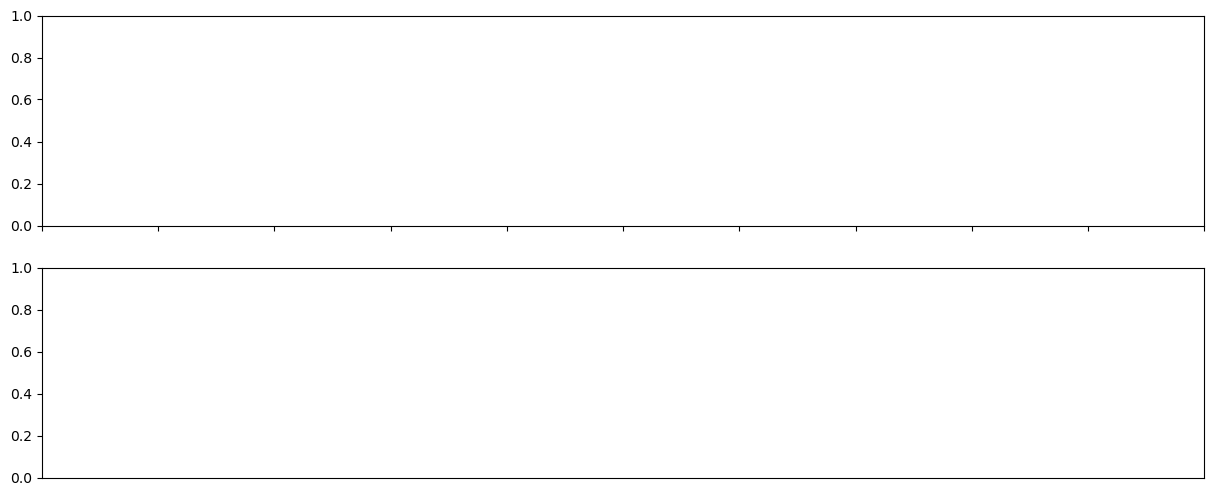

In [9]:
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(15, 6), sharex=True)

# ax.plot(date_range.to_numpy(), cell_states, c="C0", alpha=0.2)
ax.plot(date_range.to_numpy(), cell_states[:, 7], c="C0")

ax.set_ylabel("cell state")
ax2.set_ylabel("min/max temperature")

ax2.plot(date_range.to_numpy(), forcings["t_min_e5l"].to_numpy(), c="C1")
ax2.plot(date_range.to_numpy(), forcings["t_max_e5l"].to_numpy(), c="C2")
plt.tight_layout();

In [9]:
f, ax = plt.subplots(4, 2, figsize=(20, 14), sharex=True)
ax[0, 0].set_title("Input values")
lines = ax[0, 0].plot(
    dataset[0]["x_d"]
)  # these are the normalized inputs we fed the LSTM above
ax[0, 0].legend(lines, cudalstm_config.dynamic_inputs, frameon=False)

ax[1, 0].set_title("Cell state")
ax[1, 0].plot(customlstm_output[0]["c_n"][0])

ax[0, 1].set_title("Hidden state")
ax[0, 1].plot(customlstm_output[0]["h_n"][0])

ax[1, 1].set_title("Output gate")
ax[1, 1].plot(customlstm_output[0]["o"][0])

ax[2, 0].set_title("Forget gate")
ax[2, 0].plot(customlstm_output[0]["f"][0])

ax[2, 1].set_title("Input gate")
ax[2, 1].plot(customlstm_output[0]["i"][0])

ax[3, 0].set_title("Cell input activation")
ax[3, 0].plot(customlstm_output[0]["g"][0])

f.delaxes(ax[3, 1])
plt.tight_layout()

In [10]:
DEVICE = "cpu"

def get_morris_gradient(
    model: torch.nn.Module, loader: torch.utils.data.DataLoader
) -> torch.Tensor:
    """Calculate gradients w.r.t static network inputs.

    TODO: Update Docstring with ref to paper

        Parameters
    ----------
    model : nn.Module
        The PyTorch model to train
    loader : DataLoader
        PyTorch DataLoader containing the basin data in batches.

    Returns
    -------
    torch.Tensor
        [description]
    """
    model.eval()
    grads = []
    for x_d, x_s, y in loader:
        model.zero_grad()
        x_s = torch.autograd.Variable(x_s, requires_grad=True)
        x_d, x_s = x_d.to(DEVICE), x_s.to(DEVICE)
        p = model(x_d, x_s[:, 0, :])[0]
        grad = torch.autograd.grad(
            p, x_s, grad_outputs=torch.ones_like(y).to(DEVICE), create_graph=False
        )
        grads.append(grad[0][:, 0, :].detach().cpu().numpy())
    return np.concatenate(grads, axis=0)

In [27]:
cuda_lstm.eval()
grads = []
for sample in dataloader:
    cuda_lstm.zero_grad()
    x_s = sample["x_s"]
    x_d = sample["x_d"]
    y = sample["y"]

    x_s = torch.autograd.Variable(x_s, requires_grad=True)
    x_d, x_s = x_d.to(DEVICE), x_s.to(DEVICE)
    p = cuda_lstm(sample)["y_hat"]
    grad = torch.autograd.grad(
        p, x_s, grad_outputs=torch.ones_like(y).to(DEVICE), create_graph=True
    )
    grads.append(grad[0][:, 0, :].detach().cpu().numpy())

RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

In [23]:
cuda_lstm(sample)["y_hat"].shape

torch.Size([1000, 365, 1])

In [18]:
get_morris_gradient(model=cuda_lstm, loader=[sample["x_d"], sample["x_s"], sample["y"]])

ValueError: too many values to unpack (expected 3)

In [36]:
cuda_lstm(sample).keys()

dict_keys(['lstm_output', 'h_n', 'c_n', 'y_hat'])

In [32]:
# 3. Create a SHAP explainer
def custom_masker(mask, x):
    # in this simple example we just zero out the features we are masking
    return (x * mask).reshape(1, len(x))


explainer = shap.Explainer(cuda_lstm, masker=custom_masker)

shap_values = explainer(sample)

# plot the SHAP values for the positive class
shap.plots.beeswarm(shap_values[..., 1])

AttributeError: 'str' object has no attribute 'shape'